## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
import numpy as np
from os.path import join
from skimage.color import gray2rgb, rgb2gray
from skimage.io import imread
from skimage.transform import resize
import pandas as pd

In [2]:
import keras
import tensorflow as tf
from keras import backend as K
import gc

Using TensorFlow backend.


In [3]:
from keras.models import load_model

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
#IMAGE_SIZE = (197, 197)
IMAGE_SIZE = (100, 100)

In [6]:
def shift_img(img, img_points, shift_rate=0.2):
    img = np.copy(img)
    img_points = img_points[:]
    
    if np.random.rand() < .5:
        img = resize(img, (70, 70))
        
    orig_shape = img.shape[0]
    
    shift = int( (np.random.rand() * .2 + .8) * shift_rate * orig_shape )
    corner = np.random.randint(4)
    new_shape = orig_shape - shift
    shift_coord = shift / orig_shape
    resize_rate = orig_shape / new_shape
    
    def shift_points(coord, sign):
        norm_shift = .5 if sign == 1 else .5 - shift_coord
        return (coord - shift_coord * sign + norm_shift) * resize_rate - .5
    
    if corner == 0:
        img = img[shift:, shift:, :]
        for i in range(14):
            img_points[2*i] = shift_points( img_points[2*i], 1 )
            img_points[2*i+1] = shift_points( img_points[2*i+1], 1 )
        
    elif corner == 1:        
        img = img[:-shift, shift:, :]
        for i in range(14):            
            img_points[2*i] = shift_points( img_points[2*i], 1 )
            img_points[2*i+1] = shift_points( img_points[2*i+1], -1 )
        
    elif corner == 2:        
        img = img[:-shift, :-shift, :]
        for i in range(14):
            img_points[2*i] = shift_points( img_points[2*i], -1 )
            img_points[2*i+1] = shift_points( img_points[2*i+1], -1 )
        
    else:        
        img = img[shift:, :-shift, :]
        for i in range(14):            
            img_points[2*i] = shift_points( img_points[2*i], -1 )
            img_points[2*i+1] = shift_points( img_points[2*i+1], 1 )
            
    return img, img_points

In [7]:
def load_imgs_and_keypoints(dirname='data'):
    gt = pd.read_csv('data/gt.csv')
    imgs = []
    points = []
    
    print(len(gt.index))
    
    for index, row in gt.iterrows():
        #img = gray2rgb(imread('data/images/' + row["filename"]))
        img = imread('data/images/' + row["filename"])        
        if len(img.shape) > 2:
            img = rgb2gray(img)
        img = img.reshape((img.shape[0], img.shape[1], 1))        
        
        img_points = []
        for i in range(1, 15):
            img_points.append( row["x" + str(i)] / img.shape[1] - .5 )
            img_points.append( row["y" + str(i)] / img.shape[0] - .5 )

        shifted_img, shifted_img_points = shift_img(img, img_points) 
        if np.max(np.abs(shifted_img_points)) < 0.49:
            shifted_img = resize(shifted_img, IMAGE_SIZE)
            imgs.append(shifted_img)
            points.append( shifted_img_points )
        
        img = resize(img, IMAGE_SIZE)
        imgs.append(img)
        points.append( img_points )
        
    return np.array(imgs), np.array(points)

In [8]:
imgs, points = load_imgs_and_keypoints()
print(imgs.shape)
print(points.shape)
print(points[0])

6000
(8801, 100, 100, 1)
(8801, 28)
[-0.48901835 -0.26094817 -0.13278425 -0.21876256  0.06408196 -0.1953261
  0.22344985 -0.25626088 -0.4093344  -0.13907861 -0.32965046 -0.14845319
 -0.21246819 -0.11564216  0.02189634 -0.09220571  0.07345654 -0.12970403
  0.17657694 -0.10626758  0.00314718  0.17496987 -0.29683943  0.31558859
 -0.07184947  0.34371233  0.05939467  0.33902504]


array([-0.48901835, -0.26094817, -0.13278425, -0.21876256,  0.06408196,
       -0.1953261 ,  0.22344985, -0.25626088, -0.4093344 , -0.13907861,
       -0.32965046, -0.14845319, -0.21246819, -0.11564216,  0.02189634,
       -0.09220571,  0.07345654, -0.12970403,  0.17657694, -0.10626758,
        0.00314718,  0.17496987, -0.29683943,  0.31558859, -0.07184947,
        0.34371233,  0.05939467,  0.33902504])

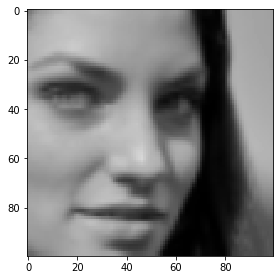

In [9]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

In [10]:
def visualize_points(img, points):
    imshow(img)
    for i in range(14):
        plt.scatter( (points[2*i] + .5 )*IMAGE_SIZE[1], (points[2*i + 1] + .5 )*IMAGE_SIZE[0], s=20, c='r')    

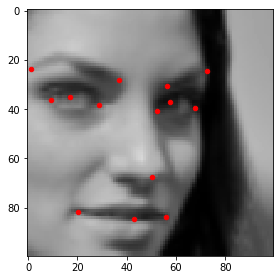

In [11]:
visualize_points(imgs[0], points[0])

In [12]:
print(imgs.shape)

(8801, 100, 100, 1)


### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [13]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1, random_state=17)

In [14]:
del imgs
del points

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

In [15]:
def flip_img(img, points):
    f_points = np.zeros(points.shape)
    f_points[:] = points
    for i in range(14):
        f_points[2*i] = -1 * f_points[2*i] 
    f_img = np.flip(img, axis=1)
    return f_img, f_points

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [16]:
aug_imgs_train, aug_points_train = [], []

for i in range(len(imgs_train)):
    f_img, f_points = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
    
aug_imgs_train, aug_points_train = np.array(aug_imgs_train), np.array(aug_points_train)

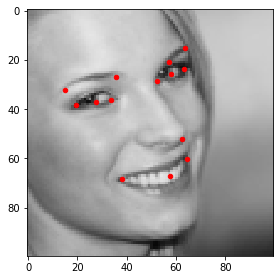

In [17]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

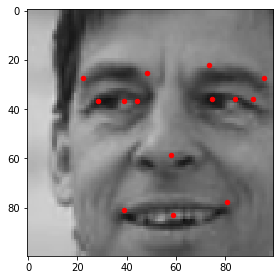

In [18]:
id = 15
visualize_points(aug_imgs_train[id], aug_points_train[id])

In [19]:
print(imgs_train.shape)
print(points_train.shape)
imgs_train_ = imgs_train
points_train_ = points_train
imgs_train = np.concatenate((imgs_train, aug_imgs_train), axis=0)
points_train = np.concatenate((points_train, aug_points_train), axis=0)
print(imgs_train.shape)
print(points_train.shape)
del imgs_train_
del points_train_

(7920, 100, 100, 1)
(7920, 28)
(15840, 100, 100, 1)
(15840, 28)


In [20]:
# additional test set:
with open('facerecogn_images.npy', 'rb') as f:
    facerecogn_images = np.load(f)

In [21]:
#facerecogn_images = np.array([ resize(img, IMAGE_SIZE) for img in facerecogn_images ])
facerecogn_images = np.array([ rgb2gray(resize( img, IMAGE_SIZE)).reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))  for img in facerecogn_images ])

In [22]:
def resnet_preprocess(imgs):
    return np.array([ keras.applications.resnet50.preprocess_input( np.copy(img) ) for img in imgs ])

In [23]:
#model_input_imgs_train = resnet_preprocess(imgs_train)
#model_input_imgs_val = resnet_preprocess(imgs_val)
#model_input_facerecogn_images = resnet_preprocess(facerecogn_images)
model_input_imgs_train = imgs_train
model_input_imgs_val = imgs_val
model_input_facerecogn_images = facerecogn_images

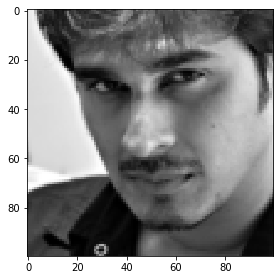

In [24]:
imshow(imgs_train[0])

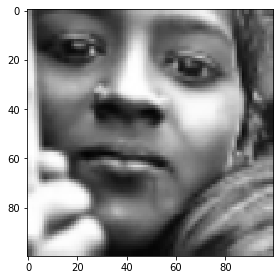

In [25]:
imshow(imgs_val[0])

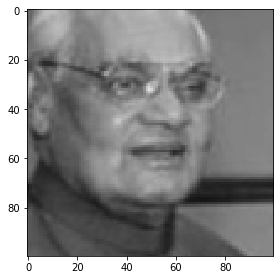

In [26]:
imshow(facerecogn_images[0])

In [27]:
def append_history(history, h_partition):
    for key in h_partition:
        history[key] = h_partition[key] if key not in history else history[key] + h_partition[key]

In [28]:
def clean_obsolete_history(history, n_last_iter):
    for key in history:
        history[key] = history[key][-n_last_iter:]

In [29]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (13, 5)

def plot_training_history(history, ylog=False):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if ylog:
        plt.yscale('log')
    plt.grid(True)
    plt.show()
    
def plot_metric_history(history, metric_name, ylog=False):
    plt.plot(history[metric_name])
    plt.plot(history['val_' + metric_name])
    plt.title('Model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if ylog:
        plt.yscale('log')
    plt.grid(True)
    plt.show()

In [30]:
def plot_lr(lr_history):    
    plt.plot(lr_history)
    plt.title('STLR')
    plt.xlabel('# of iterations')
    plt.ylabel('Learning rate')
    plt.grid(True)
    plt.show()

In [31]:
def plot_weight_norm(wn_history):    
    plt.plot(wn_history)
    plt.title('Weights norms')
    plt.xlabel('# of iterations')
    plt.ylabel('norm')
    plt.grid(True)
    plt.show()

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [32]:
class KerasSlantedTriangularLearningRateCallback(keras.callbacks.Callback):
    """
    The slanted triangular learning rate schedule used for ULMFiT https://arxiv.org/pdf/1801.06146.pdf
    """

    def __init__(self,
                 lr_max: float = 0.001,
                 cut_frac: float = 0.1,
                 ratio: float = 32):
        self.lr_max = lr_max
        self.cut_frac = cut_frac
        self.ratio = ratio
        self.lr_history = []

    def on_train_begin(self, logs = None):
        epochs = self.params['epochs']
        steps = int(self.params['samples'] // self.params['batch_size']) # self.params['steps']
        self.cut = epochs * steps * self.cut_frac
        self.iteration = 0

    def on_batch_begin(self, batch: int, logs = None):
        t = self.iteration
        cut = self.cut
        if t < cut:
            p = t / cut
        else:
            p = 1 - (t - cut) / (cut * (1 / self.cut_frac - 1))
        lr = self.lr_max * (1 + p * (self.ratio - 1)) / self.ratio
        
        K.set_value(self.model.optimizer.lr, lr)

        self.lr_history.append( float(str(K.eval(self.model.optimizer.lr))) )

        self.iteration += 1

In [33]:
def conv_layer(layer, filters, kernel, activation, stride, dropout, BN, conv_padding, init):
    layer = keras.layers.Conv2D(filters=filters,
                                kernel_size=(kernel, kernel),
                                strides=(stride,stride),
                                activation=None,
                                padding=conv_padding,
                                kernel_initializer="glorot_uniform", #init, #"glorot_normal", #keras.initializers.GlorotUniform(),
                               )(layer)
    if BN:
        layer = keras.layers.BatchNormalization(axis=-1)(layer)
    layer = keras.layers.Activation(activation)(layer)
    #layer = keras.layers.Dropout(0.1)(layer)
    return layer

In [34]:
def conv_block(layer, filters, kernel, activation, dropout, with_residual, BN, maxpool, conv_padding, init):
    residual_connection = layer
    layer = conv_layer(layer, filters, kernel, activation, 1, dropout, BN, conv_padding, init)
    
    if with_residual:
        layer = keras.layers.Add()([residual_connection, conv_layer(layer, filters, kernel, activation, 1, dropout, BN, conv_padding, init)])
        
    if maxpool:
        layer = keras.layers.MaxPooling2D(pool_size=2)(layer)
    else:
        layer = conv_layer(layer, filters, kernel, activation, 2, dropout, BN, conv_padding, init)    
    
    return layer

In [35]:
def dense_layer(layer, n_units, activation, dropout, BN, init):
    layer = keras.layers.Dense(n_units, activation=None,
                               kernel_initializer="glorot_normal", # init #"he_uniform",#tf.keras.initializers.GlorotNormal()
                              )(layer)
    if BN:
        layer = keras.layers.BatchNormalization(axis=-1)(layer)
    layer = keras.layers.Activation(activation)(layer)
    layer = keras.layers.Dropout(dropout)(layer)
    return layer

In [36]:
def create_model(activation, dropout, conv_filters, dense_sizes, BN, maxpool, conv_padding, kernels, init):
    input = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    layer = input
    
    #if BN:
    #    layer = keras.layers.BatchNormalization(axis=-1)(layer)

    #layer = keras.layers.Dropout(.1)(layer)
    
    for i, conv_filter in enumerate(conv_filters):
        layer = conv_block(layer, conv_filter, kernels[i], activation, dropout,
                           with_residual=False, BN=BN, maxpool=maxpool, conv_padding=conv_padding, init=init)
        
    #layer = keras.layers.MaxPooling2D(pool_size=2)(layer)
    
    layer = keras.layers.Flatten()(layer)

    for dense_size in dense_sizes:
        layer = dense_layer(layer, dense_size, activation, dropout, BN=BN, init=init)
    
    #layer = keras.layers.Dropout(.2)(layer)
    
    layer = keras.layers.Dense(28, activation=None, init="glorot_normal")(layer)
    model = keras.models.Model(inputs=input, outputs=layer)
    return model

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [37]:
def create_resnet(GAP, maxpool_size, dense_size, activation, dropout, BN, last_layer_name):
    model = keras.applications.resnet50.ResNet50(weights='imagenet',
                                                 include_top=False,
                                                 pooling=('avg' if GAP else None),
                                                 input_tensor=keras.layers.Input(shape=(197, 197, 3))
                                                ) # pooling: None, 'max', 'avg'
    for layer in model.layers:
        layer.trainable = False
        
    inputs = model.input
        
    def build_model(layer_name):
        layer = model.get_layer(layer_name).output
        if GAP:
            layer = keras.layers.GlobalAveragePooling2D()(layer)
        return layer
    
    if last_layer_name is None:
        layer = model.output
    else:
        layer = build_model( last_layer_name )
        
    if not GAP:
        if maxpool_size is not None:
            layer = keras.layers.MaxPooling2D(pool_size=(maxpool_size, maxpool_size))(layer)
        layer = keras.layers.Flatten()(layer)
            
    #layer = dense_layer(layer, dense_size, activation, dropout, BN)
    layer = dense_layer(layer, dense_size, activation, dropout, BN)
    layer = dense_layer(layer, dense_size, activation, dropout, BN)

    layer = keras.layers.Dense(28, activation=None)(layer)    
    model = keras.models.Model(inputs=inputs, outputs=layer)    
    return model

In [38]:
def unfreeze_resnet(model, train_portion, last_frozen_layer_name):
    # last_frozen_layer_name: activation_34 or activation_37
    n_frozen = int( len(model.layers) * (1. - train_portion) )
    layer_indices = { layer.name: i for i, layer in enumerate(model.layers) }    
    last_frozen_layer_ind = layer_indices[ last_frozen_layer_name ]
    n_frozen = np.max([n_frozen, last_frozen_layer_ind+1])    
    n_unfrozen = len(model.layers) - n_frozen
    print("n_unfrozen:", n_unfrozen, "n_frozen:", n_frozen)
    
    for layer in model.layers[ - n_unfrozen : ]:
        layer.trainable = True
    
    compile_model(model) # https://stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-weights-and-biases-in-keras-tensorflow/47996024

In [39]:
def get_weight_norm(model):
    weight_norms = []    
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            weight_norms.append( np.linalg.norm( weights[0] ) )
    return np.mean( weight_norms )

In [40]:
def smooth_L1_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true, y_pred)

In [41]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [42]:
def compile_model(model, optimizer, lr, loss):
    #optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.5, decay=0.001, nesterov=False)
    
    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(lr=lr) # , clipnorm=1.0 , clipvalue=0.5 #, beta_1=0.9, beta_2=0.99, amsgrad=False
    #optimizer = keras.optimizers.Adadelta(lr=0.01, rho=0.97)
    
    if optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(lr=lr, clipnorm=1.0)
    #optimizer = keras.optimizers.Nadam()

    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = [coeff_determination])

    #model.summary()

In [43]:
def train_resnet(model, n_iter, n_internal_iter, lr_max, lr_max_unfreeze, last_frozen_layer_name):
    
    weight_norm_history = []
    history = {}
    lr_history = []
    
    compile_model(model)
    
    #stlr = KerasSlantedTriangularLearningRateCallback(lr_max = lr_max)
    
    for i in range(n_iter):
        print("high-level iteration:", i)
        if i > 0:
            unfreeze_resnet(model, i / n_iter, last_frozen_layer_name)
            #stlr = KerasSlantedTriangularLearningRateCallback(lr_max = (lr_max_unfreeze / i))
            
        h_partition = model.fit(model_input_imgs_train, points_train,
                                batch_size=32,
                                epochs=n_internal_iter,
                                verbose=1,
                                validation_data=(model_input_imgs_val, points_val)
                                ) # callbacks=[ stlr ]
        
        weight_norm_history.append( get_weight_norm(model) )
        append_history(history, h_partition.history)
        #lr_history += stlr.lr_history
    
    return history, weight_norm_history, lr_history

In [44]:
def run_resnet_experiment(experiment_id, n_iter, n_internal_iter, lr_max, lr_max_unfreeze,
                          GAP, maxpool_size, dense_size, activation, dropout,
                          BN, last_layer_name, last_frozen_layer_name):
    sess = tf.InteractiveSession()
    K.set_session(sess)
    
    print("----------------------")
    print(experiment_id)
    print("params:", GAP, maxpool_size, dense_size, activation, dropout, BN, last_layer_name, last_frozen_layer_name)
    
    model = create_resnet(GAP, maxpool_size, dense_size, activation, dropout, BN, last_layer_name)
    model.summary()
    history, weight_norm_history, lr_history = train_resnet(model, n_iter, n_internal_iter, lr_max,
                                                            lr_max_unfreeze, last_frozen_layer_name)
    
    val_loss = np.round( np.mean(history['val_loss'][-5:]), 4 )    
        
    print("----------------------")
    print(experiment_id)    
    print("val_loss:", val_loss)
    print("params:", GAP, maxpool_size, dense_size, activation, dropout, BN, last_layer_name, last_frozen_layer_name)
    print("----------------------")
    
    with open( 'resnet_hyperparams.txt', 'a') as file:
        file.write( str((experiment_id, n_iter, n_internal_iter, lr_max, lr_max_unfreeze,
                         GAP, maxpool_size, dense_size, activation, dropout, BN, last_layer_name,
                         last_frozen_layer_name,
                         val_loss)) + '\n')
        
    model.save('resnet_models/rn_facial_keypoints_regressor_{}.h5'.format(experiment_id))
    
    sess.close()    
    K.clear_session()
    gc.collect()
    
    return model, history, weight_norm_history

hist_set = []
for experiment_id in range(31, 1000):
    n_iter = 15
    n_internal_iter = 3
    lr_max = 0.1
    lr_max_unfreeze = 0.001    
    GAP = False # np.random.choice( [False, True] )
    maxpool_size = None # 3 # np.random.choice( [ 2, 3] )
    dense_size = 1024 #np.random.choice( [ 256, 512, 1024 ] )
    activation = 'selu' #np.random.choice( [ "relu", "selu" ] )
    dropout = 0.3 # np.random.choice( [ 0.3, 0.5 ] )
    BN = True
    last_layer_name = None # np.random.choice( ["activation_22", "activation_40", None] )
    last_frozen_layer_name = np.random.choice( [ "activation_34", "activation_37" ] )
    model, history, weight_norm_history = run_resnet_experiment(experiment_id,
                                                                n_iter,
                                                                n_internal_iter,
                                                                lr_max,
                                                                lr_max_unfreeze,
                                                                GAP,
                                                                maxpool_size,
                                                                dense_size,
                                                                activation,
                                                                dropout,
                                                                BN,
                                                                last_layer_name,
                                                                last_frozen_layer_name)
    hist_set.append( history )
    plot_training_history(history, ylog=True)
    plot_weight_norm(weight_norm_history)
    print("==================================")

In [45]:
def train(model, epochs, patience, lr_max, optimizer, lr, loss):
    compile_model(model, optimizer, lr, loss)
    
    stlr = KerasSlantedTriangularLearningRateCallback(lr_max = lr_max)
    #estop = keras.callbacks.EarlyStopping(   monitor='val_acc', # 'val_loss',
    #                                         patience=patience,
    #                                         verbose=1,
    #                                         mode="auto")
    
    history = model.fit(model_input_imgs_train, points_train,
                        batch_size=768,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(model_input_imgs_val, points_val),
                        callbacks=[stlr])    
            
    weight_norm = get_weight_norm(model)
    
    return history.history, weight_norm, None

In [46]:
def run_experiment(experiment_id, activation, dropout, conv_filters, dense_sizes, BN,
                   epochs, patience, lr_max, optimizer, lr, maxpool, conv_padding, kernels, loss, init, sess):
    
    if sess is not None:
        sess.close()    
        
    K.clear_session()    
    sess = tf.InteractiveSession()
    K.set_session(sess)
    
    print("----------------------")
    print("params:", activation, dropout, conv_filters, dense_sizes, BN, optimizer,
                     lr, maxpool, patience, conv_padding, kernels,
                     loss, init)
    
    model = create_model(activation, dropout, conv_filters, dense_sizes, BN, maxpool, conv_padding, kernels, init)
    model.summary()
    history, weight_norm, lr_history = train(model, epochs, patience, lr_max, optimizer, lr, loss)
    
    if patience != 0:
        val_loss = np.round( np.mean(history['val_loss'][-(patience+5):-patience]), 4 )
        val_coeff_determination = np.round( np.mean(history['val_coeff_determination'][-(patience+5):-patience]), 4 )
    else:
        val_loss = np.round( np.mean(history['val_loss'][-5:]), 4 )
        val_coeff_determination = np.round( np.mean(history['val_coeff_determination'][-5:]), 4 )
    epochs = len(history['val_loss'])
    weight_norm = np.round(weight_norm)
    
    print("----------------------")
    print(experiment_id)    
    print("val_loss:", val_loss, "val_coeff_determination:", val_coeff_determination, "epochs:", epochs)
    print("params:", activation, dropout, conv_filters, dense_sizes, BN, optimizer,
                     lr, maxpool, patience, conv_padding, kernels,
                     loss, init)
    print("----------------------")
    
    with open( 'hyperparams.txt', 'a') as file:
        file.write( str((experiment_id, activation, dropout, conv_filters, dense_sizes,
                         BN, epochs, weight_norm, lr_max, optimizer, lr, maxpool, patience,
                         conv_padding, kernels, loss, init,
                         val_loss, val_coeff_determination)) + '\n')
        
    model.save('models/facial_keypoints_regressor_{}.h5'.format(experiment_id))
    
    sess.close()    
    K.clear_session()
    gc.collect()
    
    return model, history, weight_norm, sess

hist_set = []
for experiment_id in range(2618, 4000):
    activation = np.random.choice( ["relu"] )
    conv_filters = [ [16, 16, 16], [16, 16, 32], [16, 32, 32], [32, 32, 32] ]
    kernels = [ [3, 3, 3], [7, 3, 3], [3, 3, 3], [5, 3, 3] ]
    conv_filters_idx = np.random.choice( len(conv_filters) )
    conv_filters = conv_filters[ conv_filters_idx ]    
    kernels = kernels[ conv_filters_idx ]
    conv_padding = np.random.choice( ["valid"] )
    dropout = np.random.choice([ 0.1, 0.2, 0.3 ])
    dense_sizes = [ [512, 32], [512, 64], [512, 128], [512, 256], [512, 512] ]
    dense_sizes = dense_sizes[ np.random.choice( len(dense_sizes) ) ]
    init = "glorot" # np.random.choice([ "glorot_normal", "glorot_uniform", "he_normal", "he_uniform" ])
    BN = np.random.choice([ True ])
    lr_max = np.random.choice([ 0.01, 0.05, 0.1, 0.5 ])
    epochs = 5
    patience = 0 # np.random.choice([ 10 ])
    optimizer = np.random.choice(["adam"])
    loss = smooth_L1_loss # np.random.choice( [smooth_L1_loss, "mse"] )
    lr = np.random.choice([ 0.001 ])
    maxpool = np.random.choice( [ True ] )
    sess = None
    
    try:
        model, history, weight_norm, sess = run_experiment(experiment_id, activation, dropout, conv_filters,
                                                     dense_sizes, BN, epochs, patience, lr_max, optimizer, lr,
                                                     maxpool, conv_padding, kernels, loss, init, sess)
        hist_set.append( history )
        plot_training_history(history, ylog=True)
        plot_metric_history(history, "coeff_determination", ylog=False)
        print("weight_norm:", weight_norm)
    except Exception as ex:
        print(ex)    
    
    print("==================================")

In [47]:
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"smooth_L1_loss": smooth_L1_loss, "coeff_determination": coeff_determination})
#model = load_model('models/facial_keypoints_regressor_3971.h5')

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [48]:
#def predict(img_data, img_display):
#    points_pred = model.predict(img_data.reshape((1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)))[0]
#    visualize_points(img_display, points_pred)

In [60]:
def plot_images(images, points_list, folder):
    images = np.array(images)
    figure = plt.figure(figsize=(15, 15))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)
        image = images[i, :]
        points = points_list[i, :]
        visualize_points(image, points)
        plt.axis('off')
    #plt.show()
    with open('{}/{}.png'.format(folder, experiment_id), 'wb') as file:
        figure.savefig(file, bbox_inches='tight')
        plt.close(figure)

In [61]:
def predict(model, imgs_data, imgs_display, folder):
    points_pred = model.predict(np.array(imgs_data))
    plot_images(imgs_display, points_pred, folder)

In [62]:
#predict(model_input_facerecogn_images[:5].tolist() + model_input_imgs_val[:5].tolist(),
#         facerecogn_images[:5].tolist() + imgs_val[:5].tolist())

In [ ]:
for experiment_id in range(2058, 4000):
    print ("======= Experiment: {} =======".format(experiment_id))
    try:
        model = load_model('models/facial_keypoints_regressor_{}.h5'.format(experiment_id))
        predict(model,
                model_input_facerecogn_images[:5].tolist() + model_input_imgs_val[:5].tolist(),
                facerecogn_images[:5].tolist() + imgs_val[:5].tolist(),
                'output_examples')
        K.clear_session()
        gc.collect()
    except Exception as ex:
        print(ex)

In [ ]:
for experiment_id in [1681, 1685, 1686, 1687, 1688,
                      1700, 1718, 1740, 1760, 1762, 1782,
                      1811, 1828, 1832, 1857, 1875,
                      1907, 1944, 1945, 1962, 1971, 1994,
                      2000, 2085, 2196, 2446, 2529, 2547, 2574, 2580, 2597, 2608, ]:
    print ("======= Experiment: {} =======".format(experiment_id))
    try:
        model = load_model('models/facial_keypoints_regressor_{}.h5'.format(experiment_id))
        predict(model,
                #model_input_facerecogn_images[:25].tolist(),
                model_input_imgs_val[:25].tolist(),
                #facerecogn_images[:25].tolist(),
                imgs_val[:25].tolist(),
                'good_output_examples')        
    except Exception as ex:
        print(ex)
        
    K.clear_session()
    gc.collect()

We choose model models/facial_keypoints_regressor_1681.h5